#How to use YoloV5 on Custom Dataset

* <font size='3'>In this notebook, you will be shown how to train a YoloV5 Object detection model on a custom dataset.
* <font size='3'>For this notebook, we are using the dataset given below from roboflow:
https://universe.roboflow.com/my-game-pics/my-game-pics
* <font size='3'>This dataset is an animal object detection dataset which localizes the animals in the given image
* <font size='3'>For now, there are only 5 animal classes present in this dataset:

    <font size='3'>1. **Coyote**

    <font size='3'>2. **Deer**

    <font size='3'>3. **Hog**

    <font size='3'>4. **Rabbit**

    <font size='3'>5. **Raccoon**


* <font size='3'>Since I have already downloaded the dataset from Roboflow and uploaded it to drive, I will use Drive Download(**!gdown**) Command to download it on current runtime


In [ ]:
# Downloading the dataset
!gdown --id 16u5_p5pb6WfH0xVqzGmpipD0tX1z0Bbv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16u5_p5pb6WfH0xVqzGmpipD0tX1z0Bbv
To: /content/Animal_Detection.zip
100% 638M/638M [00:02<00:00, 267MB/s]


* <font size='3'>Since the dataset is compressed in a zip format, we need to unzip it in order to work on it

In [ ]:
!unzip Animal_Detection.zip

* <font size='3'>After unzipping, let us try to visualize the sample images with their respective bounding boxes

In [ ]:
# importing necessary libraries
import os
import yaml
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

* <font size='3'>The dataset in YOLO format always comes with a data.yaml file.

* <font size='3'>The data.yaml file that stores necessary information about our dataset.

* <font size='3'>It mainly contains:

  1. <font size='3'>Specifies where our training, validation and test data(in some cases) is
  2. <font size='3'>The number of classes that we want to detect
  3. <font size='3'>The names corresponding to those classes

* <font size='3'>In our case it looks something as given below


  ```
      # data.yaml
      train: ../train/images
      val: ../valid/images
      test: ../test/images

      nc: 5
      names: ['Coyote', 'Deer', 'Hog', 'Rabbit', 'Raccoon']
  ```


* <font size='3'>Let's load that file as well as it will be important for visualiztion

In [ ]:
# Load the data.yaml file
data_yaml_path = "/content/data.yaml"
with open(data_yaml_path, "r") as file:
    data = yaml.safe_load(file)

# Get the class labels
class_labels = data["names"]

*  <font size='3'>Specify the image directories along with their labels

In [ ]:
train_images="/content/train/images"
train_labels="/content/train/labels"
valid_images="/content/valid/images"
valid_labels="/content/valid/labels"
test_images="/content/test/images"
test_labels="/content/test/labels"

* <font size='3'>Create a function to visualize sample images

In [ ]:
def visualize_samples(images_path, annotations_path, class_labels, num_samples=10, figure_size=(24, 12), colors=None):
    """
    Function to visualize the sample images with their repsective bounding boxes
    """
    # Setting the colors value
    if colors is None:
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

    # Randomly Selecting Samples
    sample_indices = np.random.choice(len(os.listdir(images_path)), num_samples, replace=False)

    # Matplotlib Figure Setup
    plt.figure(figsize=figure_size)

    # Loop Over Selected Samples
    for i, idx in enumerate(sample_indices):
        # Reading Image and Annotation
        image_file = os.listdir(images_path)[idx]
        image_path = os.path.join(images_path, image_file)
        label_file = image_file.replace(".jpg", ".txt").replace(".png", ".txt")
        label_path = os.path.join(annotations_path, label_file)

        image = cv2.imread(image_path)
        height, width, _ = image.shape


        # Reading Annotations:
        with open(label_path, "r") as file:
            annotations = file.readlines()

        # Visualizing the images
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        # Visualizing Bounding Boxes and Labels:
        for j, annotation in enumerate(annotations):
            class_id, x, y, w, h = map(float, annotation.split())
            x *= width
            y *= height
            w *= width
            h *= height

            color = colors[j % len(colors)]

            bbox = cv2.rectangle(image, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), color, 2)
            bbox = cv2.putText(bbox, class_labels[int(class_id)], (int(x - w / 2), int(y - h / 2 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        plt.imshow(cv2.cvtColor(bbox, cv2.COLOR_BGR2RGB))

    plt.suptitle("Sample Images with Bounding Boxes", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Run this to visualize samples from the training directory
visualize_samples(train_images, train_labels, class_labels)

In [ ]:
# Run this to visualize samples from the validation directory
visualize_samples(valid_images, valid_labels, class_labels)

* <font size='3'>After getting a close look at our data, download the yolov5 model from the git repo

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.66 MiB | 22.67 MiB/s, done.
Resolving deltas: 100% (10983/10983), done.


* <font size='3'>Install the required dependencies

In [ ]:
!pip install -U -r yolov5/requirements.txt

* <font size='3'>Restart the runtime for the libraries to load. Don't worry, this won't delete our files and models that we have downloaded earlier

In [ ]:
%cd /content/yolov5 # Changing the current working directory

/content/yolov5


* <font size='3'>Train and Fine-Tune the model. Here, I am using YOLOV5S because of lower computational power

In [ ]:
!python train.py \ # Training Script File
    --img-size 640 \  # Image Dimensions while training
    --batch-size 32 \ # Batch Sizes of Each Iterations
    --epochs 10 \ # Number of Epochs it will train on
    --data /content/data.yaml \ # Specifying the Dataset Directories
    --cfg models/yolov5s.yaml \ # Model to use
    --weights yolov5s.pt \ # Weights file to save in current working directory
    --optimizer Adam\ # Optimzer to use
    --hyp /content/yolov5/data/hyps/hyp.scratch-low.yaml # File for calling hyperparameters. This file can be edited in order to fine-tune the model

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/content/data.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.001, lrf=0.01, momentum=0.9, weight_decay=0.0001, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamm

* <font size='3'>Based on the results, we can say that the model has generalized all the animals in the validation set pretty well.

* <font size='3'>We have can see the final results in the below PrettyTable

In [ ]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()

# Define column names
table.field_names = ["Class", "Images", "Instances", "P", "R", "mAP50", "mAP50-95"]

# Add data rows
data = [
    ["all", 526, 802, 0.929, 0.883, 0.967, 0.673],
    ["Coyote", 526, 1, 0.787, 1, 0.995, 0.895],
    ["Deer", 526, 390, 0.97, 0.874, 0.959, 0.662],
    ["Hog", 526, 294, 0.934, 0.898, 0.95, 0.653],
    ["Rabbit", 526, 7, 1, 0.744, 0.964, 0.522],
    ["Raccoon", 526, 110, 0.957, 0.9, 0.967, 0.635],
]

for row in data:
    table.add_row(row)

# Print the pretty table
print(table)

+---------+--------+-----------+-------+-------+-------+----------+
|  Class  | Images | Instances |   P   |   R   | mAP50 | mAP50-95 |
+---------+--------+-----------+-------+-------+-------+----------+
|   all   |  526   |    802    | 0.929 | 0.883 | 0.967 |  0.673   |
|  Coyote |  526   |     1     | 0.787 |   1   | 0.995 |  0.895   |
|   Deer  |  526   |    390    |  0.97 | 0.874 | 0.959 |  0.662   |
|   Hog   |  526   |    294    | 0.934 | 0.898 |  0.95 |  0.653   |
|  Rabbit |  526   |     7     |   1   | 0.744 | 0.964 |  0.522   |
| Raccoon |  526   |    110    | 0.957 |  0.9  | 0.967 |  0.635   |
+---------+--------+-----------+-------+-------+-------+----------+


* <font size='3'>Tensorboard is used to visualize how the model has performed on each epochs as well as to visualize Confidence Curve of each metrics

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

* <font size='3'>Finally run the detection script to detect animals(objects) in the test images

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source /content/test/images
# conf indicates confidence threshold between 0 to 1, 0.25 has been set in order for excellent detections so that our model might not miss some detections.

* <font size='3'>Here, the confidence threshold is set to 0.25, which means that only objects detected with a confidence score greater than or equal to 0.25 will be considered valid detections.
* <font size='3'>The threshold has been set to lower as it allows the model to capture a broader range of potential animals that had came.

* <font size='3'>Visualizing the predictions on Test Images

In [ ]:
# Calling the predicted images from predictions directory
import os
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("runs/detect/exp2"):
    predicted_files.extend(filenames)

In [ ]:
from IPython.display import Image
import random

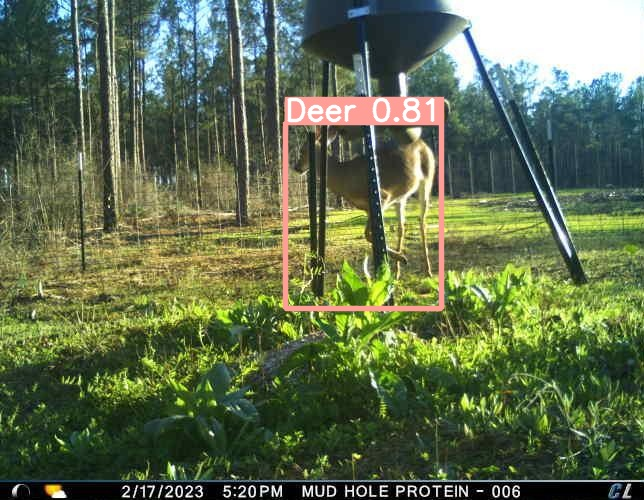

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

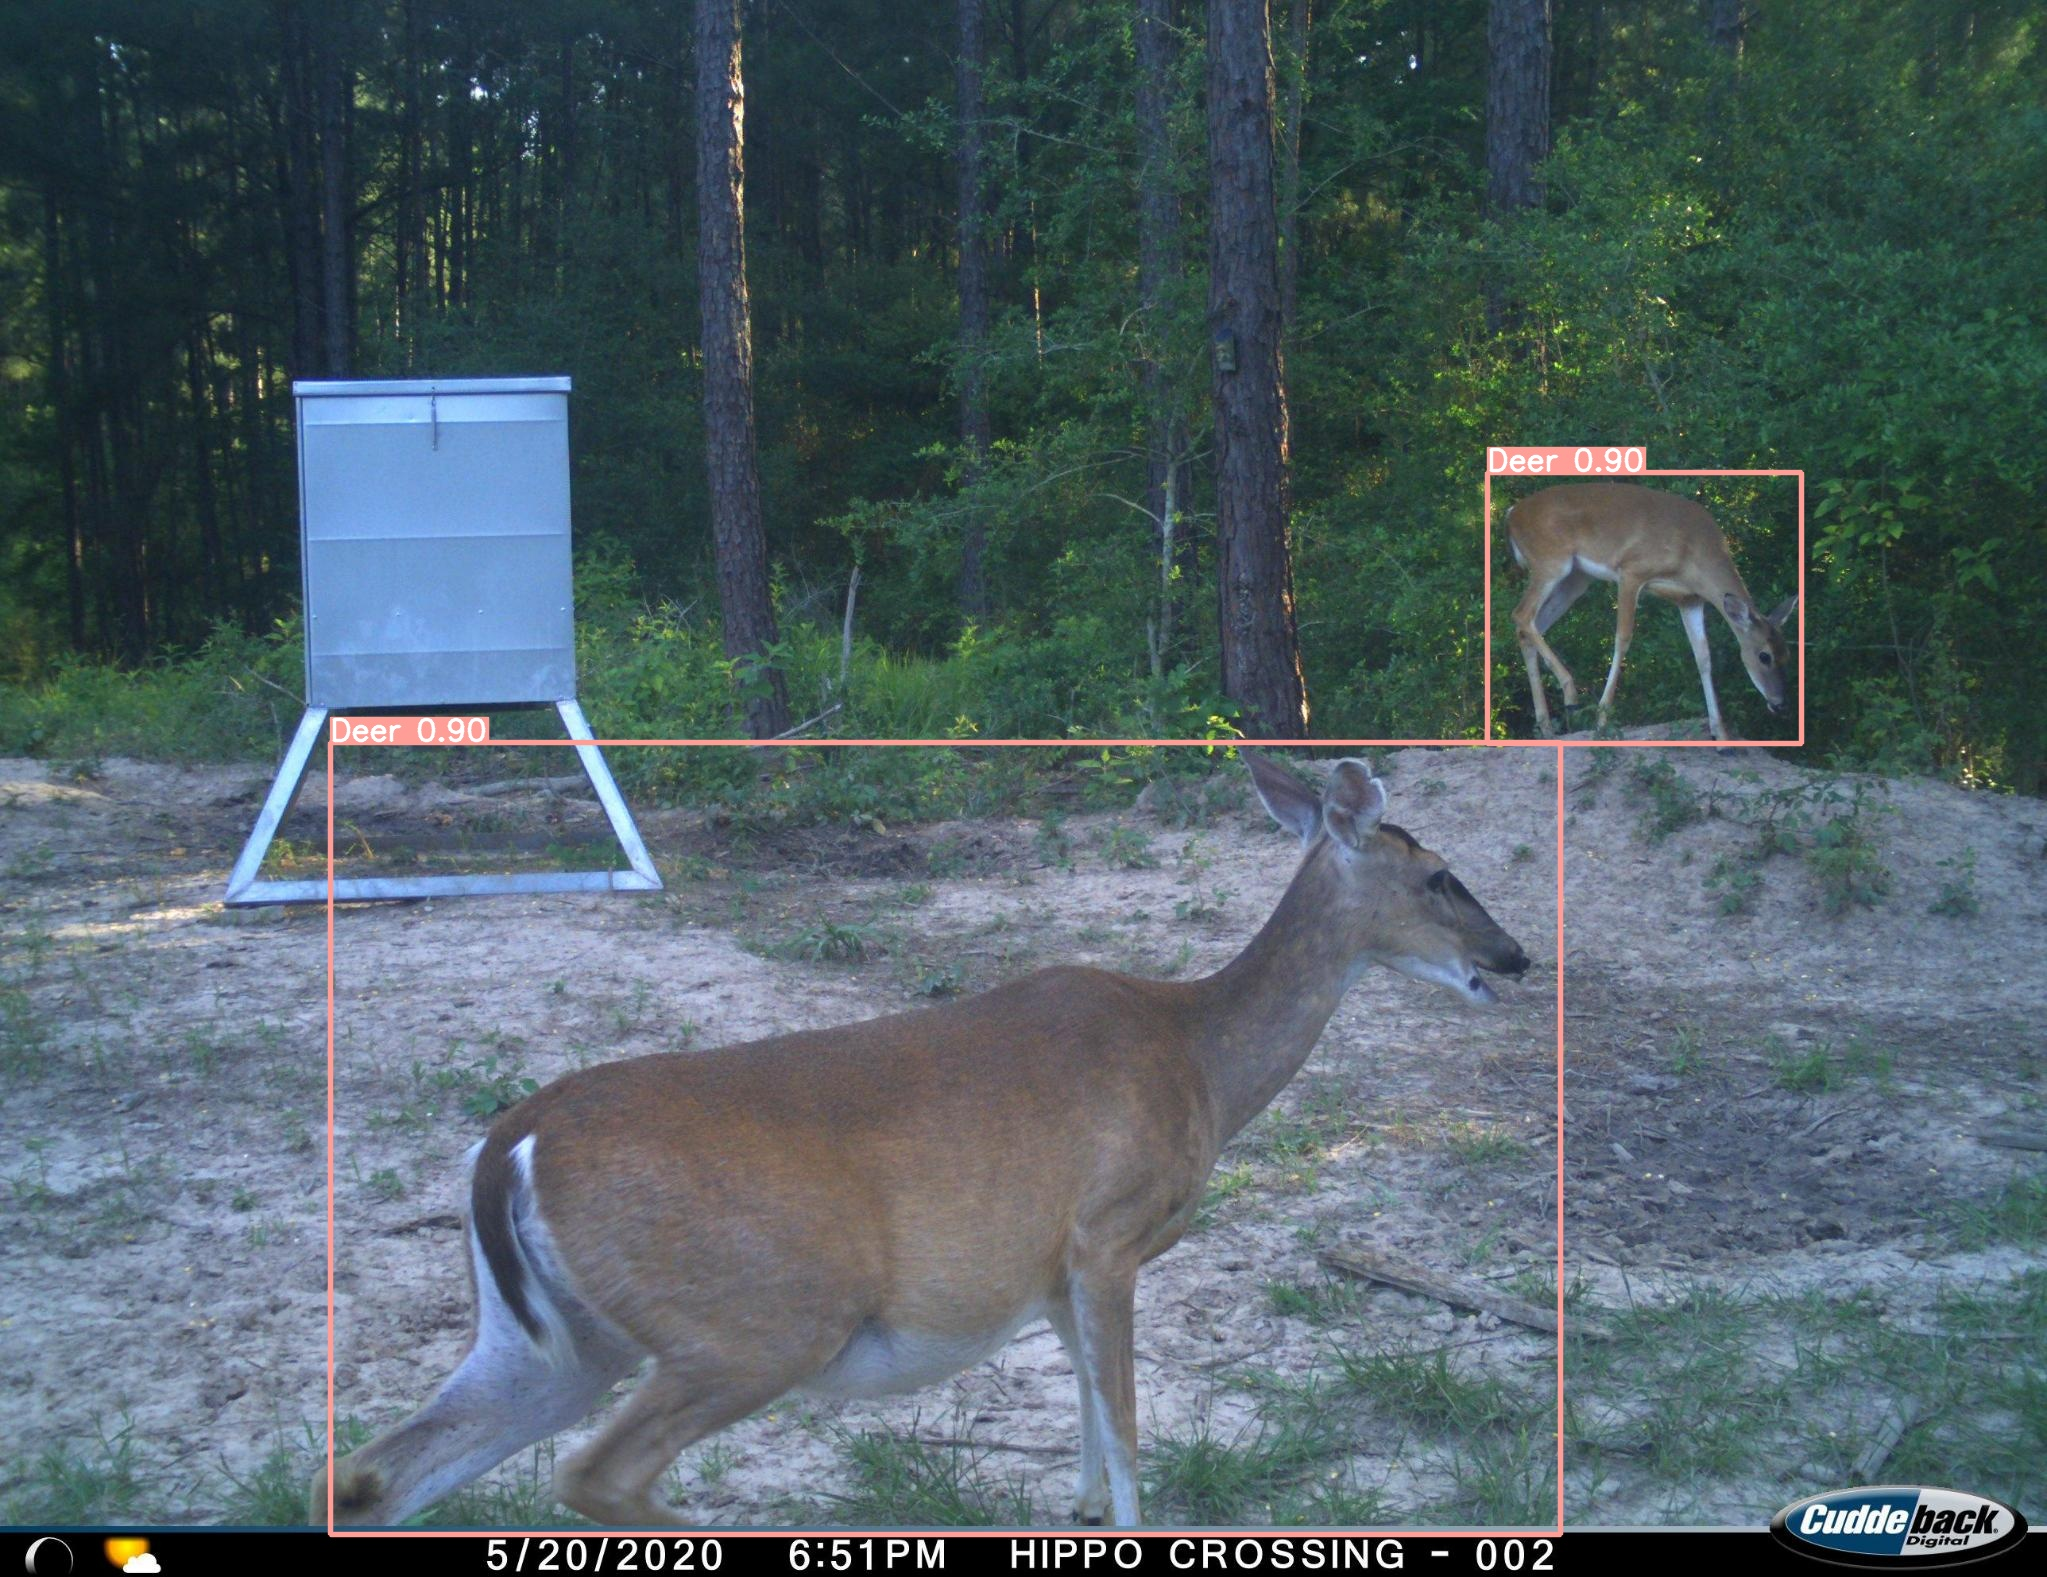

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

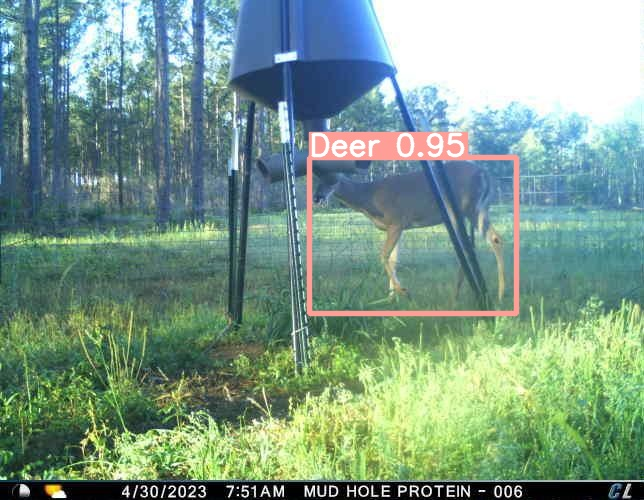

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

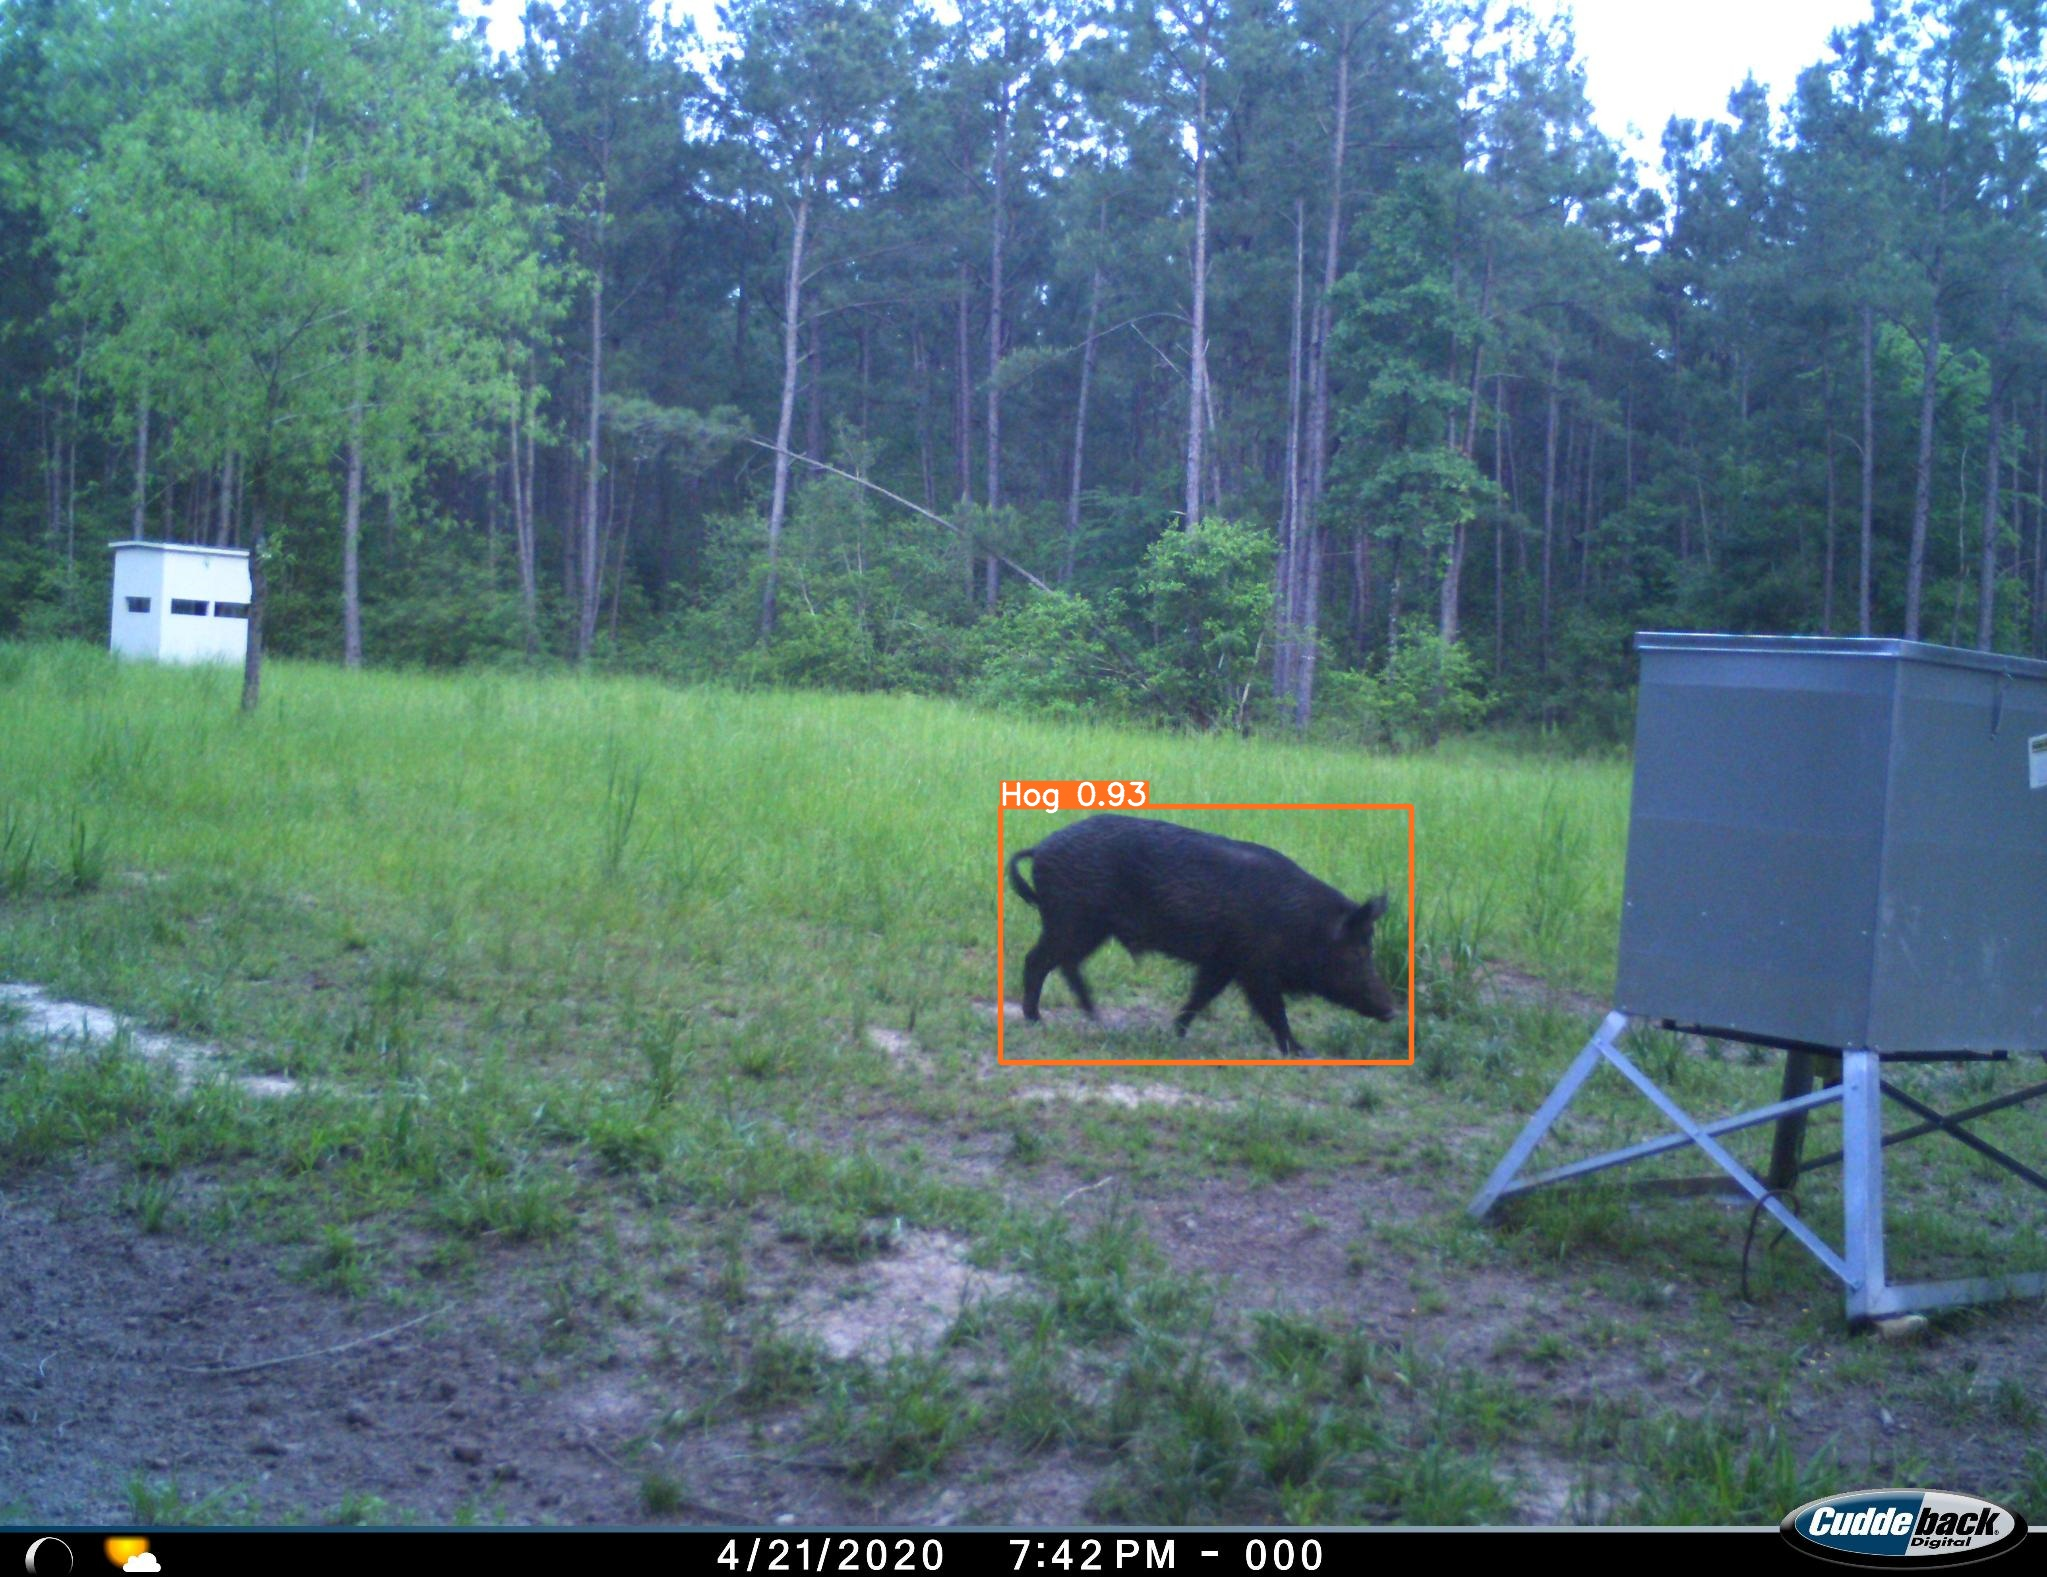

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

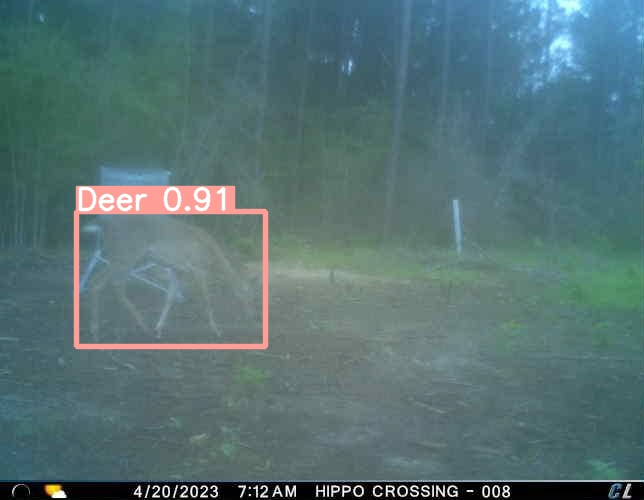

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

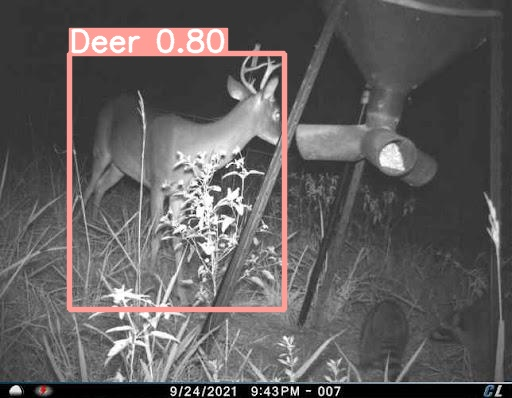

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

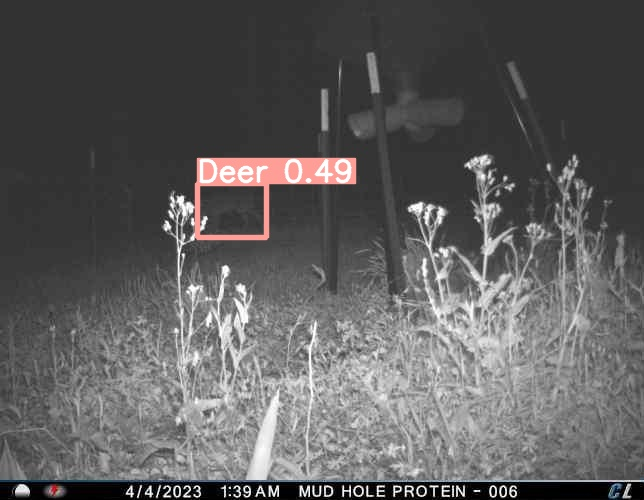

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

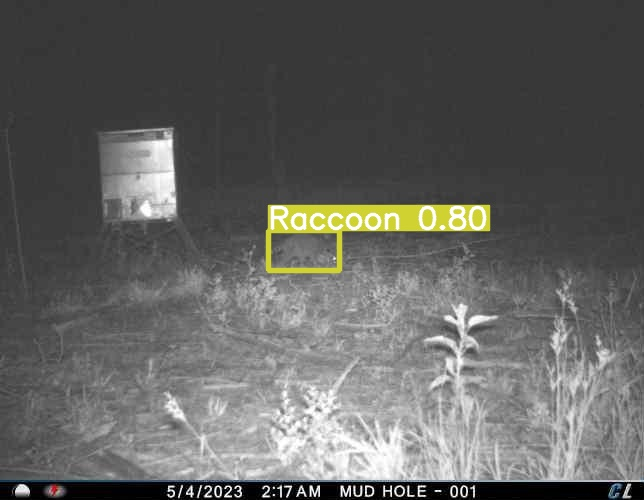

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

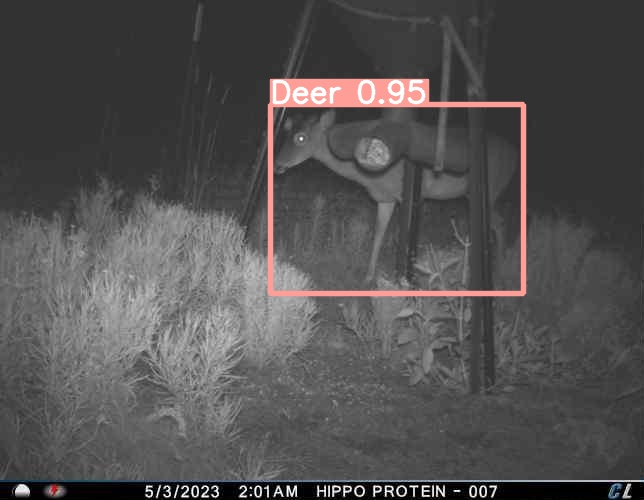

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

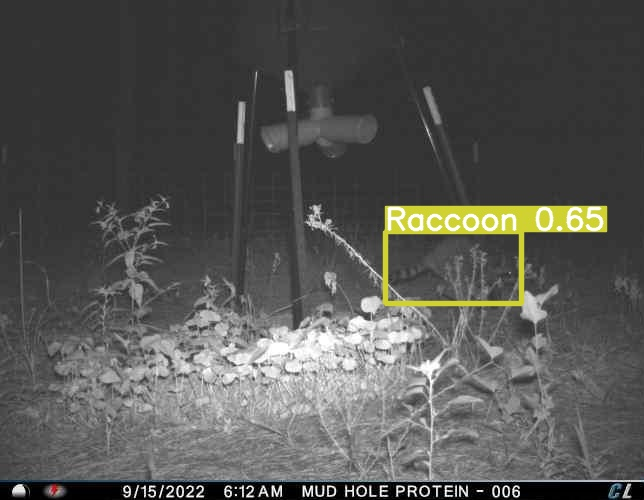

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

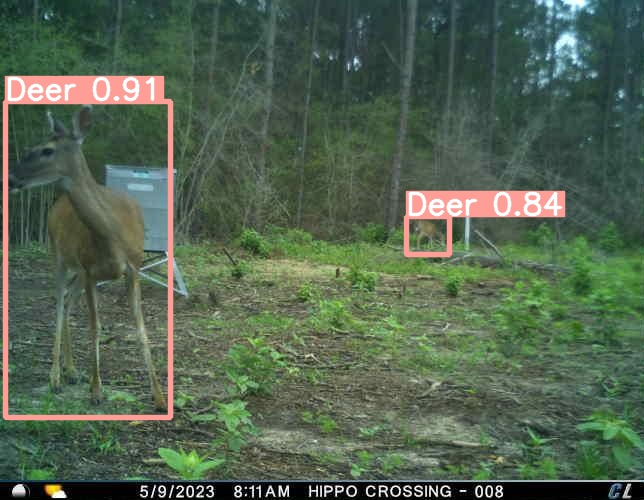

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

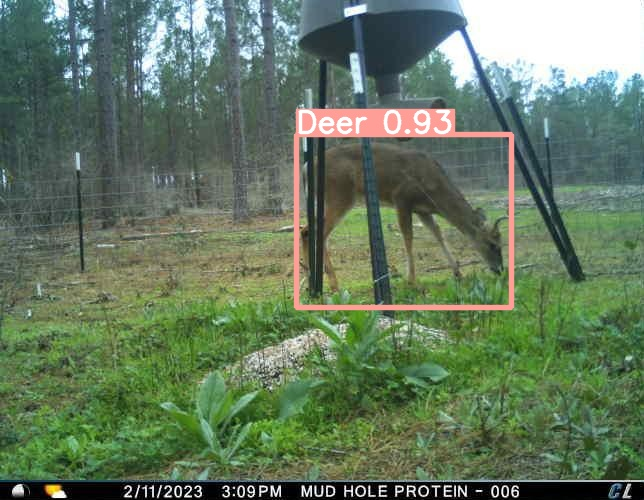

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

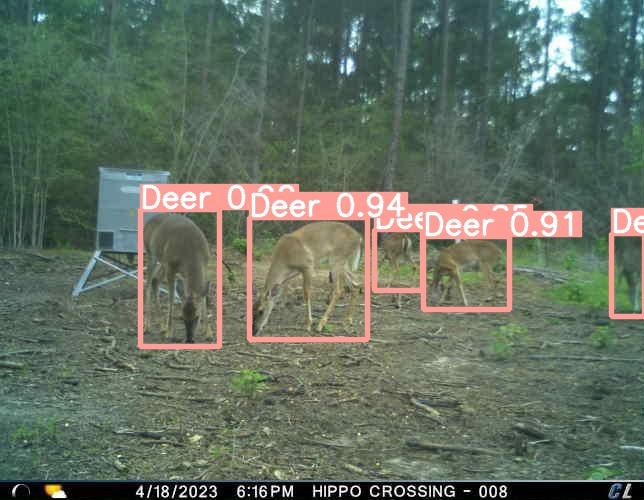

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

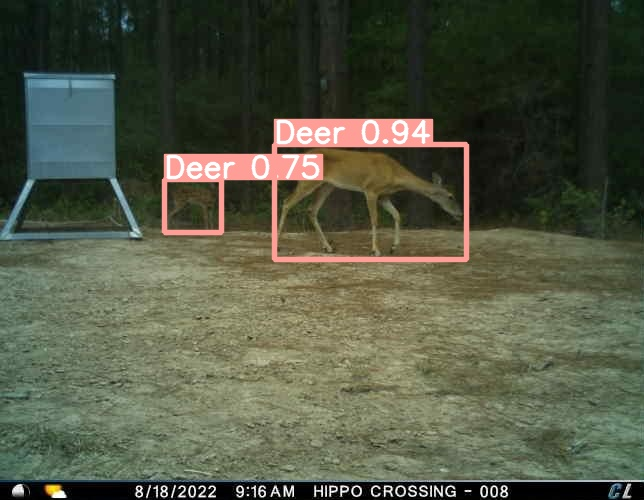

In [ ]:
Image(filename=f'runs/detect/exp/{random.choice(predicted_files)}')

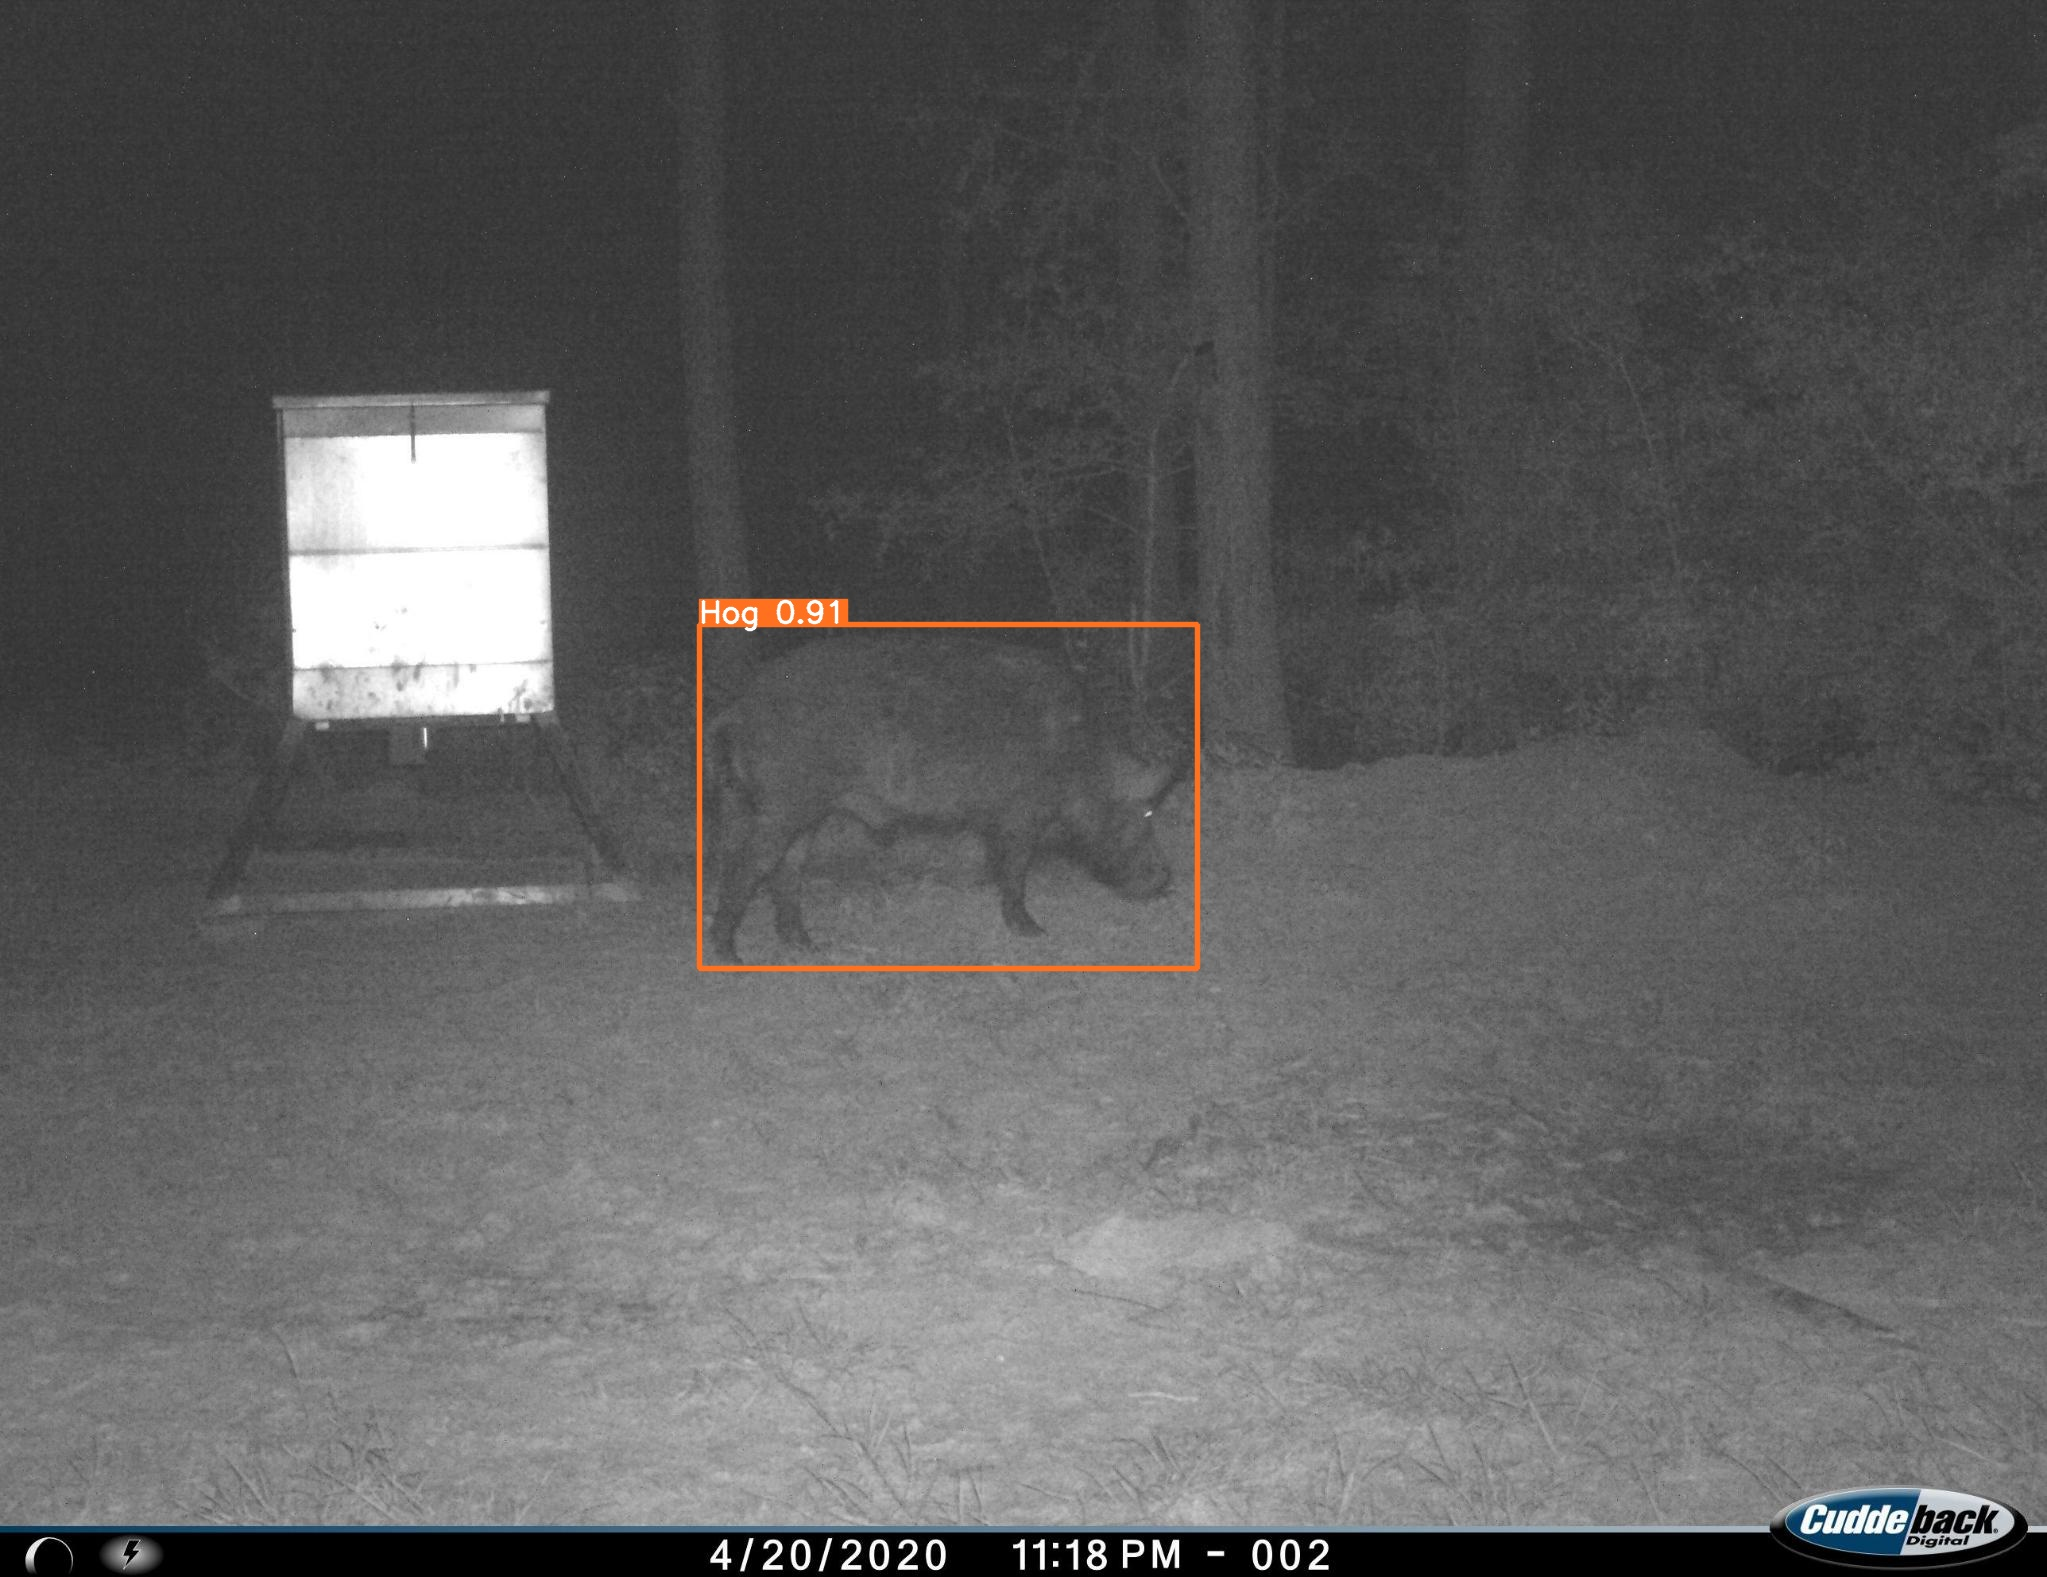

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

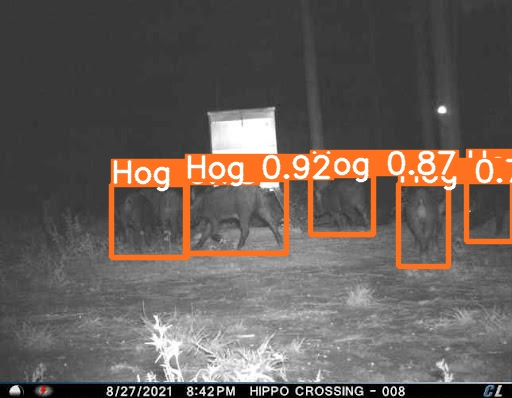

In [ ]:
Image(filename=f'runs/detect/exp2/{random.choice(predicted_files)}')

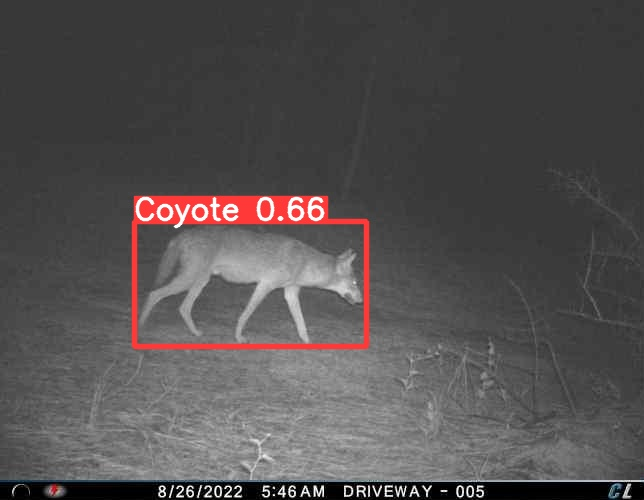

In [ ]:
Image(filename=f'runs/detect/exp2/Deer-DRIVEWAY-20220826_054648_JPG.rf.1b9ce9719d396b741437b167da80befa.jpg')

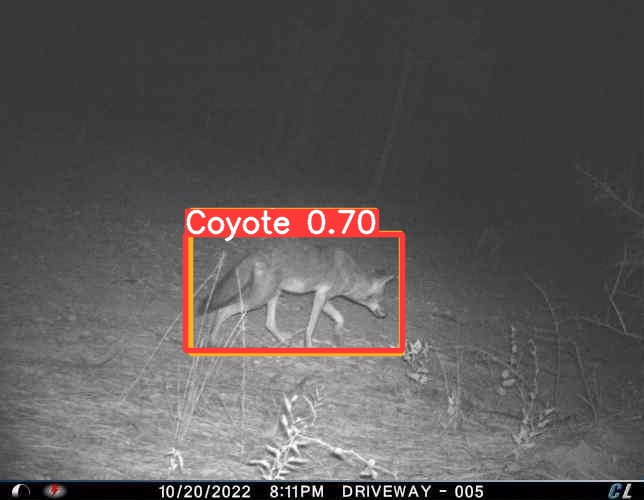

In [ ]:
Image(filename=f'runs/detect/exp2/T_00002_jpg.rf.41f7f66a33eed1eee27dbe0176d9a71c.jpg')

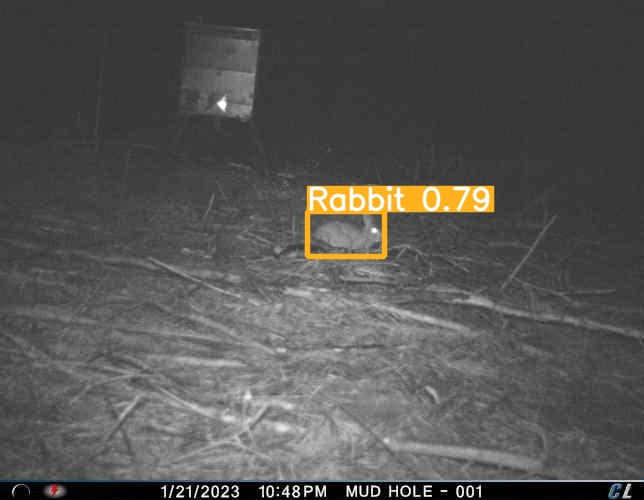

In [ ]:
Image(filename=f'runs/detect/exp2/be4ccb1c-8c89-4d42-92ed-9462157c32b5_jpg.rf.61a15672bce1dc07b81527aa27f772d0.jpg')

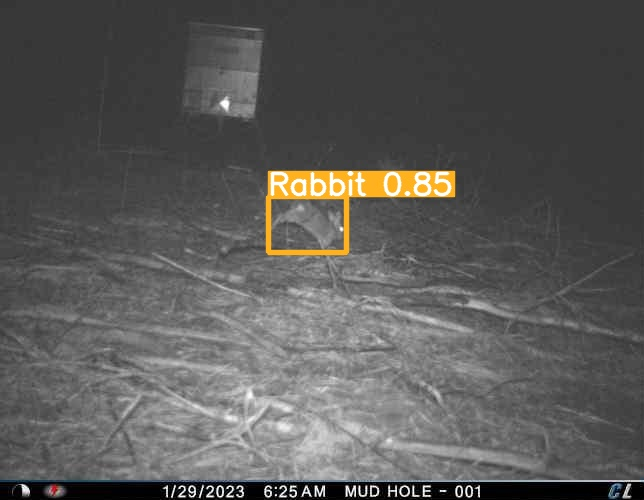

In [ ]:
Image(filename=f'runs/detect/exp2/d4d52f8e-4f24-4780-9f0b-dcb3924f2037_jpg.rf.9a65772312431f2ada0301cb06529e27.jpg')

* <font size='3'>Based on the Visualizations of predictions, it can be said that model generalizes well on test set as well keeping the confidence threshold to 0.25